In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [109]:
pip install scikeras


In [117]:
# Importing important libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, Dropout
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
df = pd.read_csv(r"C:/Users/varun/OneDrive/Documents/Guvi/Final Project Guvi/AAPL.csv")
df.head

<bound method NDFrame.head of             Date        Open        High         Low       Close   Adj Close  \
0     1980-12-12    0.513393    0.515625    0.513393    0.513393    0.407747   
1     1980-12-15    0.488839    0.488839    0.486607    0.486607    0.386473   
2     1980-12-16    0.453125    0.453125    0.450893    0.450893    0.358108   
3     1980-12-17    0.462054    0.464286    0.462054    0.462054    0.366972   
4     1980-12-18    0.475446    0.477679    0.475446    0.475446    0.377609   
...          ...         ...         ...         ...         ...         ...   
9818  2019-11-19  267.899994  268.000000  265.390015  266.290009  266.290009   
9819  2019-11-20  265.540009  266.079987  260.399994  263.190002  263.190002   
9820  2019-11-21  263.690002  264.010010  261.179993  262.010010  262.010010   
9821  2019-11-22  262.589996  263.179993  260.839996  261.779999  261.779999   
9822  2019-11-25  262.709991  266.440002  262.519989  266.369995  266.369995   

         

In [3]:
df.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [4]:
# Handling missing values 
df_columns = ['Open','High','Low','Close','Adj Close']
df[df_columns] = df[df_columns].fillna(method='ffill')
df['Volume'] = df['Volume'].fillna(0)

C:\Users\varun\AppData\Local\Temp\ipykernel_5556\3006438950.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[df_columns] = df[df_columns].fillna(method='ffill')


In [5]:
# Checking missing values after handling them
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9823 entries, 0 to 9822
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9823 non-null   object 
 1   Open       9823 non-null   float64
 2   High       9823 non-null   float64
 3   Low        9823 non-null   float64
 4   Close      9823 non-null   float64
 5   Adj Close  9823 non-null   float64
 6   Volume     9823 non-null   float64
dtypes: float64(6), object(1)
memory usage: 537.3+ KB


In [69]:
# Changing the Dtype of 'Date' column
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)


In [8]:
# Shape of the data
df.shape

(9823, 7)

In [9]:
numeric_col = ['Open','High','Low','Close','Adj Close','Volume']
df[numeric_col] = df[numeric_col].astype(float)

In [10]:
# Using 'Adj Close' as target variable
target_col = 'Adj Close'
target_data = df[[target_col]].values

In [70]:
# Data Normalization
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(target_data)

In [186]:
# Get dates for plotting
dates = df.index

In [210]:
# Spliting data (Train on 2018, Test on 2019)
train_mask = df.index.year == 2018
test_mask = df.index.year == 2019

train_data = scaled_data[train_mask]
test_data = scaled_data[test_mask]

# Get corresponding dates
train_dates = dates[train_mask]
train_prices = target_data[train_mask]
test_dates = dates[test_mask]

In [214]:
def create_sequence(data, dates, seq_length):
    X, y_actual, seq_dates = [], [], []
    for i in range(len(data) - seq_length - 10):  # 10 for max prediction
        X.append(data[i : i + seq_length])
        y_actual.append([
            data[i + seq_length],
            data[i + seq_length + 4],
            data[i + seq_length + 9]
        ])
        # Store the prediction date (date at end of sequence + prediction horizon)
        seq_dates.append(dates[i + seq_length])
    return np.array(X), np.array(y_actual), np.array(seq_dates)

seq_length = 100  # using 100 days history
X_train_raw, y_train_actual, train_pred_dates = create_sequence(train_data, train_dates, seq_length)
X_test, y_test, test_pred_dates = create_sequence(test_data, test_dates, seq_length)

In [215]:
# Reshape and scale input sequences
X_train_scaled = np.array([
    scaler.fit_transform(x.reshape(-1, 1)).flatten() 
    for x in X_train_raw
])

In [216]:
print(f"X_train_scaled shape: {X_train_scaled.shape}")  # (n_samples, seq_length)
print(f"y_train_actual shape: {y_train_actual.shape}")  # (n_samples, 3)
print(f"train_dates length: {len(train_dates)}")        # Must equal n_samples

X_train_scaled shape: (141, 100)
y_train_actual shape: (141, 3, 1)
train_dates length: 251


In [217]:
# 1. Reshape y_train_actual
y_train_actual = y_train_actual.reshape(141, 3)  # Now shape is (141, 3)

# 2. Align dates
train_dates = train_dates[-141:]  # Matches 141 samples

# 3. Verify
print(f"X_train_scaled shape: {X_train_scaled.shape}")  # (141, 100)
print(f"y_train_actual shape: {y_train_actual.shape}")  # (141, 3)
print(f"train_dates length: {len(train_dates)}")  # 141

X_train_scaled shape: (141, 100)
y_train_actual shape: (141, 3)
train_dates length: 141


In [188]:
def build_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        SimpleRNN(32),
        Dropout(0.3),
        Dense(3)  # 3 outputs for 1-day, 5-day, 10-day predictions
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(3)  # 3 outputs
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [219]:
# Train Models 
def evaluate_training_performance(model, X_train_scaled, y_train_actual, train_dates, X_test, y_test, scaler, model_name):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(
        X_train_scaled, y_train_actual,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )
     # Plot training history
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training History', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('MSE Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

    # Generate predictions
    y_pred_scaled = model.predict(X_train_scaled)
    
    # Inverse scaling
    y_train_actual_unscaled = scaler.inverse_transform(y_train_actual.reshape(-1, 1)).reshape(y_train_actual.shape)
    y_pred_actual_unscaled = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(y_pred_scaled.shape)
    
    horizons = ['1-Day', '5-Day', '10-Day']
    
    # Plot for each horizon
    plt.figure(figsize=(15, 10))
    for i, horizon in enumerate(horizons):
        plt.subplot(3, 1, i+1)
        plt.plot(train_dates, y_train_actual_unscaled[:, i], label='Actual Price', linewidth=2)
        plt.plot(train_dates, y_pred_actual_unscaled[:, i], label='Predicted Price', linestyle='--')
        
        # Calculate MSE
        mse = mean_squared_error(y_train_actual_unscaled[:, i], y_pred_actual_unscaled[:, i])
        
        plt.title(f'{model_name} - {horizon} (2018 Training Data | MSE: {mse:.4f})', fontsize=12)
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('Price ($)', fontsize=10)
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()  

In [191]:
# Evaluation with dates 
def evaluate_model(model, X_test, y_test, test_dates, scaler, model_name):
    y_pred = model.predict(X_test)

    # Reshape for inverse transform
    y_test_flat = y_test.reshape(-1,1)
    y_pred_flat = y_pred.reshape(-1,1)

    # Inverse scaling
    y_test_actual = scaler.inverse_transform(y_test_flat).reshape(y_test.shape)
    y_pred_actual = scaler.inverse_transform(y_pred_flat).reshape(y_pred.shape)

    # Preparing dates for each horizon
    date_1day = test_dates
    date_5day = test_dates
    date_10day = test_dates

    # Evaluate each horizon
    horizons = ['1-Day','5-Day','10-Day']
    date_list = [date_1day, date_5day, date_10day]

    all_results = []

    for i ,(horizon, dates) in enumerate(zip(horizons, date_list)):
        actual = y_test_actual[:,i]
        pred = y_pred_actual[:,i]
        
        mse = mean_squared_error(actual, pred)
        print(f"{model_name} - {horizon} MSE: {mse:.4f}")
        
        # Plot predictions vs actual with dates
        plt.figure(figsize=(14, 6))
        plt.plot(dates, actual, label='Actual Price', linewidth=2)
        plt.plot(dates, pred, label='Predicted Price', linestyle='--')
        plt.title(f'{model_name} - {horizon} Price Prediction (2019 Test Data)', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Adjusted Close Price ($)', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        all_results.append((dates, actual, pred))
    
    return all_results


In [192]:
# 4. Comparison function 
def plot_comparison(rnn_results, lstm_results):
    horizons = ['1-Day', '5-Day', '10-Day']
    
    for i, horizon in enumerate(horizons):
        rnn_dates, rnn_actual, rnn_pred = rnn_results[i]
        lstm_dates, lstm_actual, lstm_pred = lstm_results[i]
        
        plt.figure(figsize=(16, 6))
        plt.plot(rnn_dates, rnn_actual, label='Actual Price', color='black', linewidth=2)
        plt.plot(rnn_dates, rnn_pred, label='RNN Predicted', linestyle='--', color='blue')
        plt.plot(lstm_dates, lstm_pred, label='LSTM Predicted', linestyle='--', color='red')
        
        plt.title(f'Model Comparison - {horizon} Price Prediction (2019 Test Data)', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Adjusted Close Price ($)', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training RNN...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - loss: 1.3222 - val_loss: 0.2057
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3916 - val_loss: 0.0336
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2966 - val_loss: 0.0134
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.3062 - val_loss: 0.0135
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2462 - val_loss: 0.0247
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2128 - val_loss: 0.0170
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1784 - val_loss: 0.0389
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1697 - val_loss: 0.0100
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1592 - val_loss: 0.0101
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1371 - val_loss: 0.0087
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1576 - val_loss: 0.0064
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - los

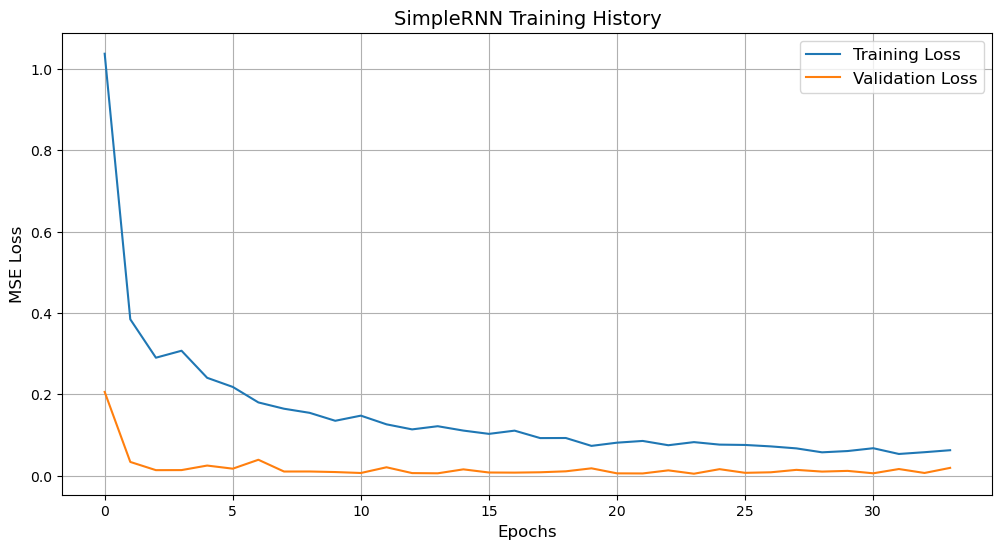

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


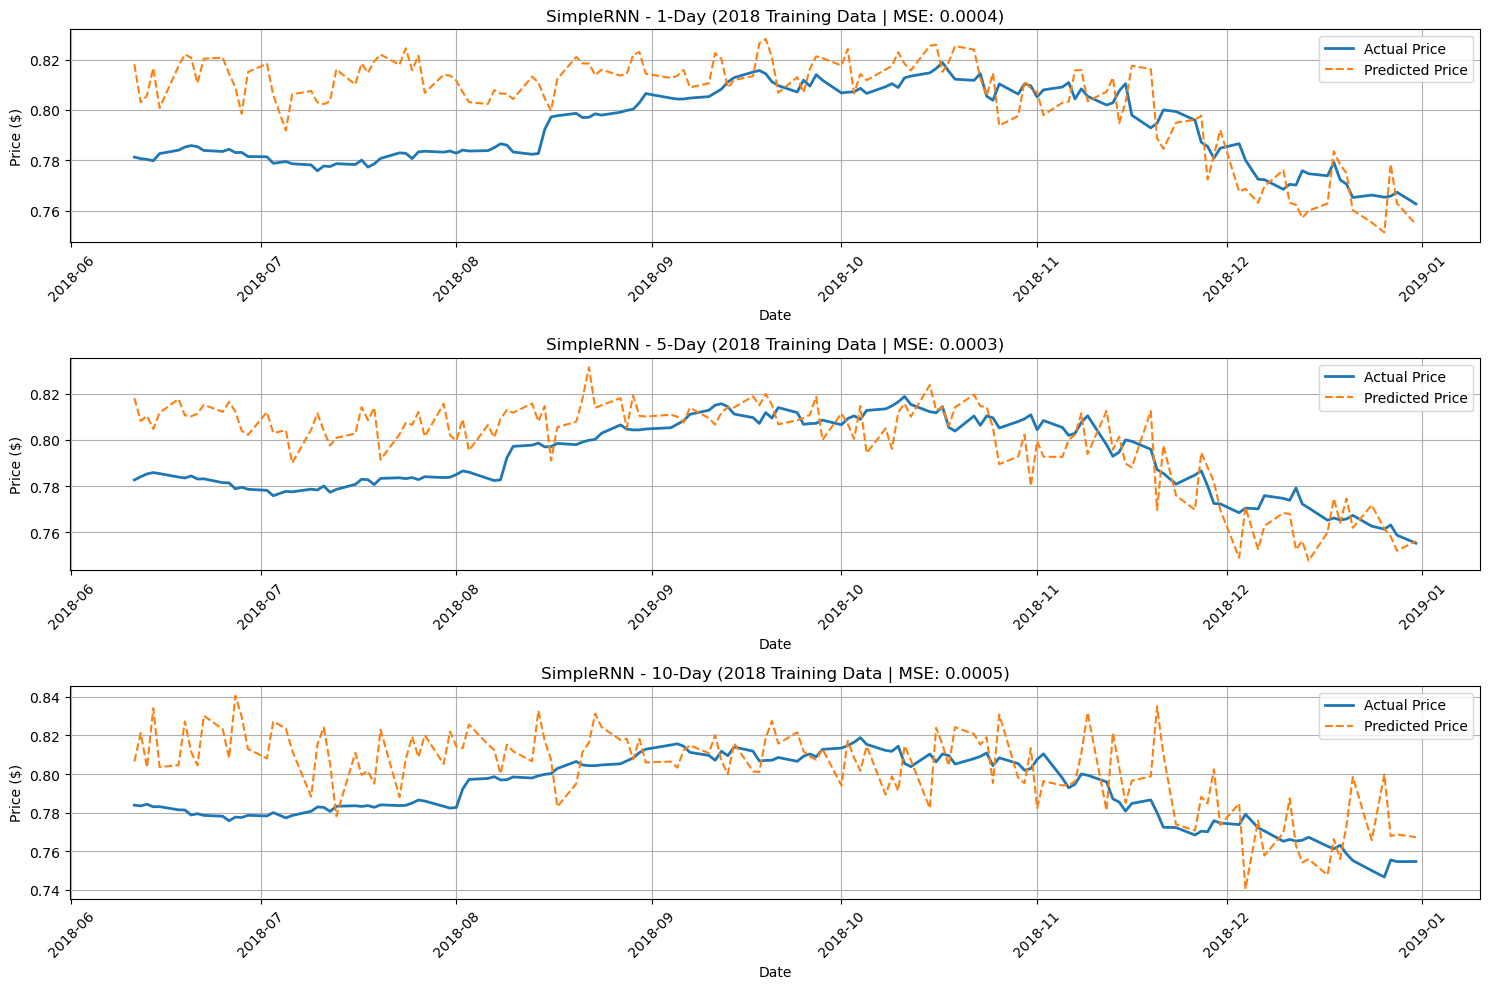


Training LSTM...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - loss: 0.4665 - val_loss: 0.2746
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1675 - val_loss: 0.0041
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0718 - val_loss: 0.0077
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0553 - val_loss: 0.0230
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0492 - val_loss: 0.0315
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0447 - val_loss: 0.0175
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0447 - val_loss: 0.0076
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0423 - val_loss: 0.0080
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0387 - val_loss: 0.0142
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0343 - val_loss: 0.0156
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0389 - val_loss: 0.0111
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - lo

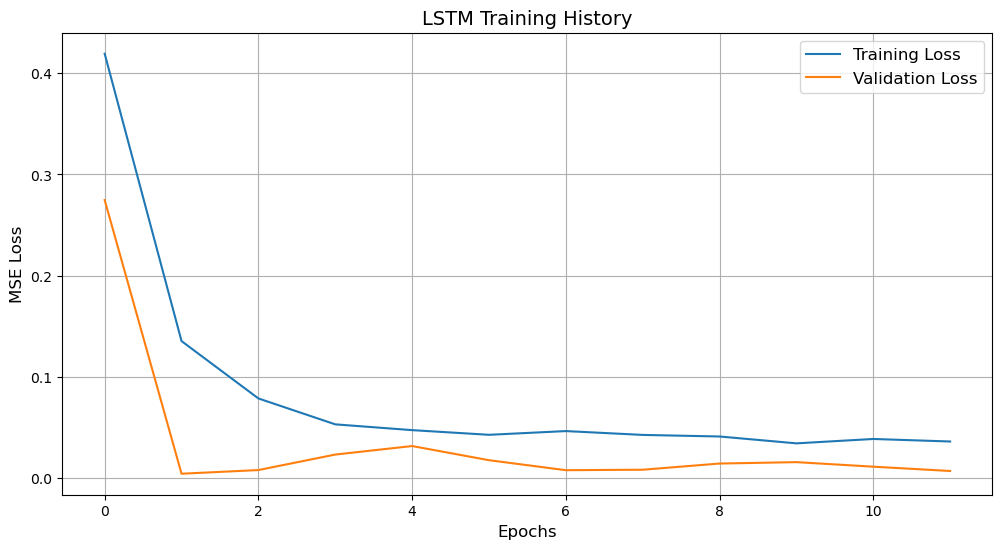

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


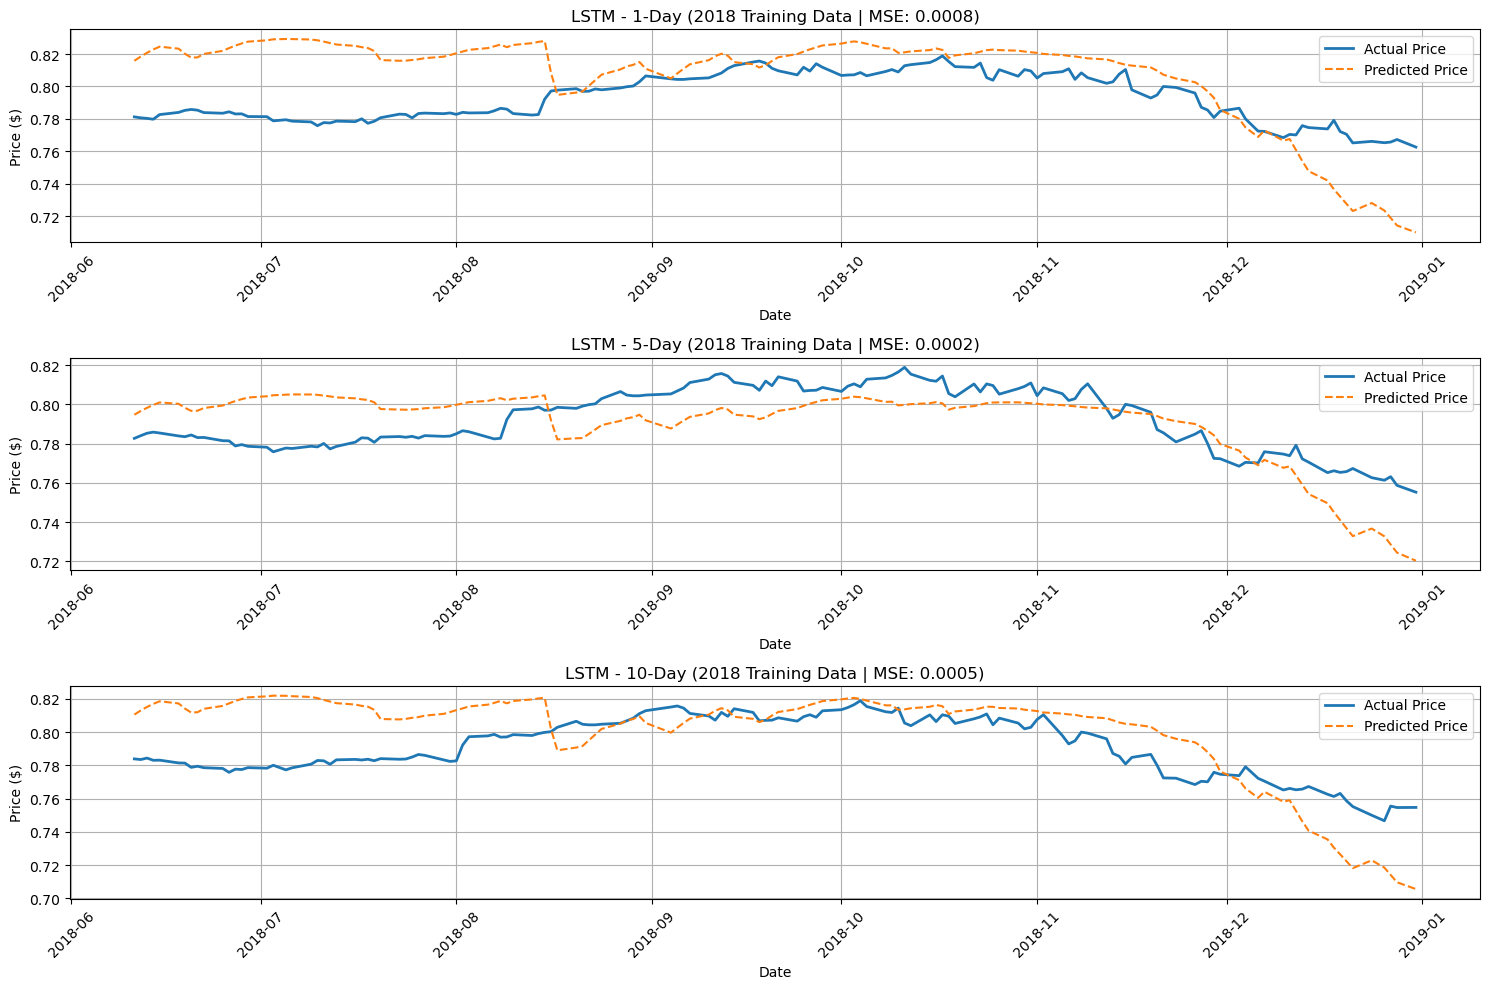

In [221]:
# Main execution
if __name__ == "__main__":
    # Initialize models
    input_shape = (X_train_scaled.shape[1],1)  # (seq_length=100, features=1)
    
    rnn_model = build_rnn_model(input_shape)
    lstm_model = build_lstm_model(input_shape)
    
    # Train and visualize
    print("Training RNN...")
    rnn_model = evaluate_training_performance(rnn_model, X_train_scaled, y_train_actual, train_dates, X_test,y_test,scaler, "SimpleRNN")
    
    print("\nTraining LSTM...")
    lstm_model = evaluate_training_performance(lstm_model, X_train_scaled, y_train_actual,train_dates,X_test,y_test, scaler, "LSTM")


SimpleRNN Evaluation:
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 624ms/step
SimpleRNN - 1-Day MSE: 193.2051


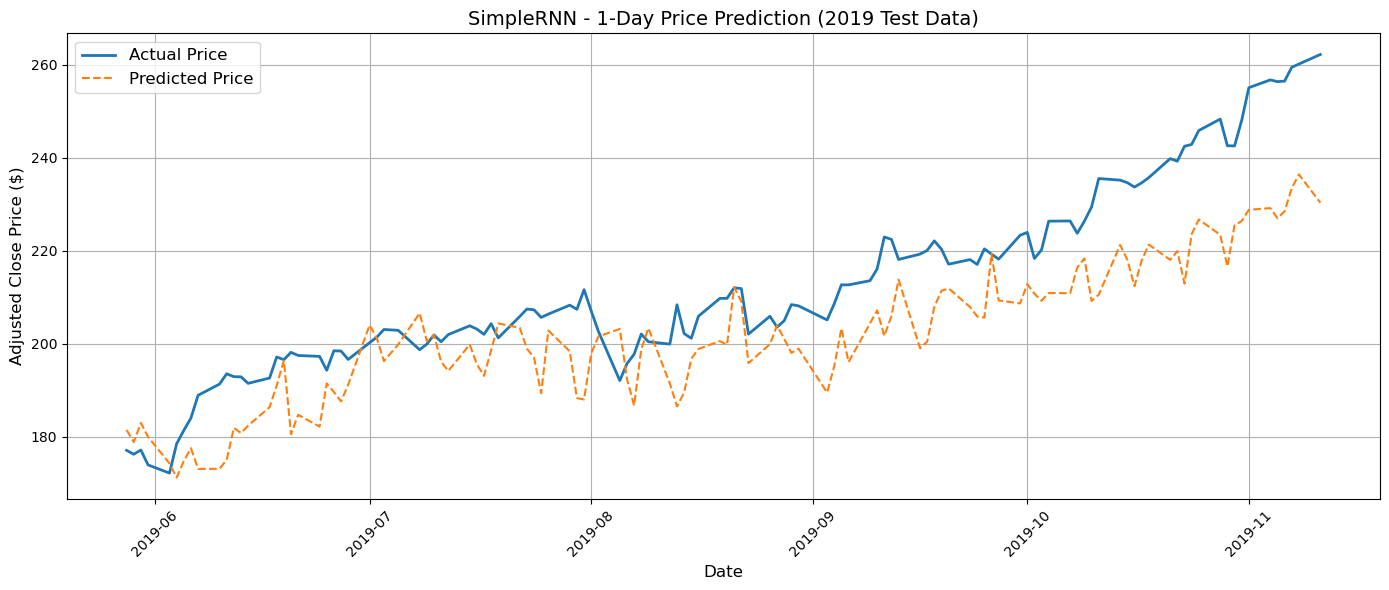

SimpleRNN - 5-Day MSE: 2113.3677


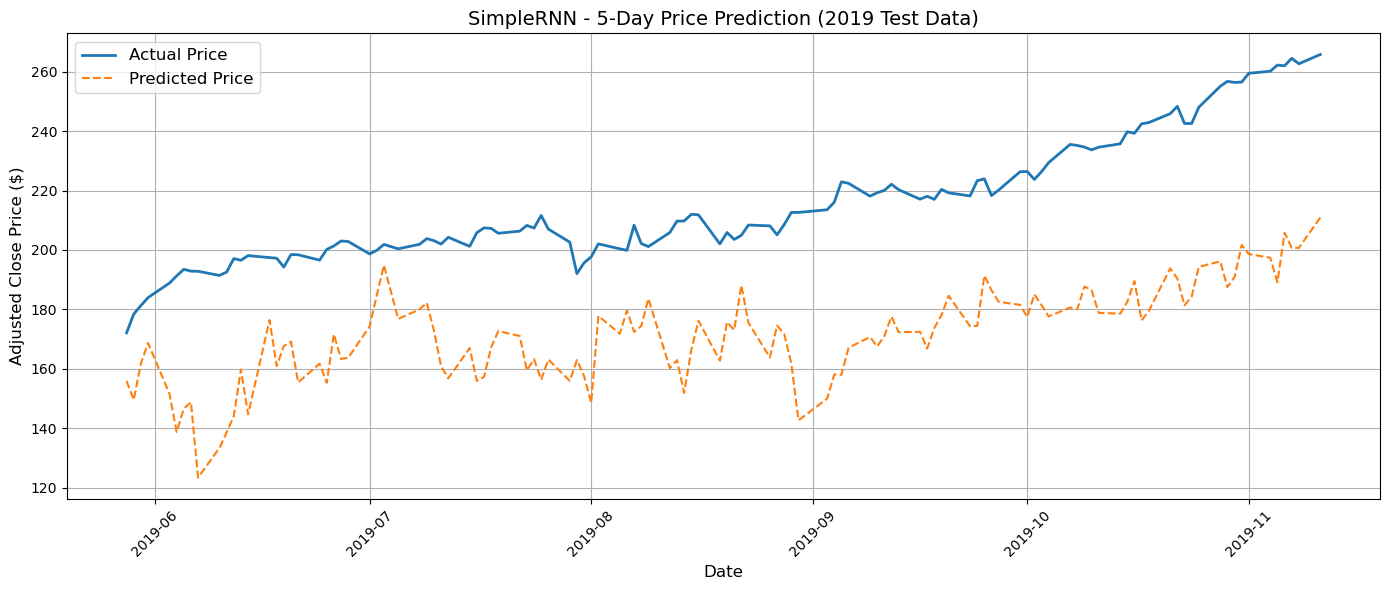

SimpleRNN - 10-Day MSE: 570.8118


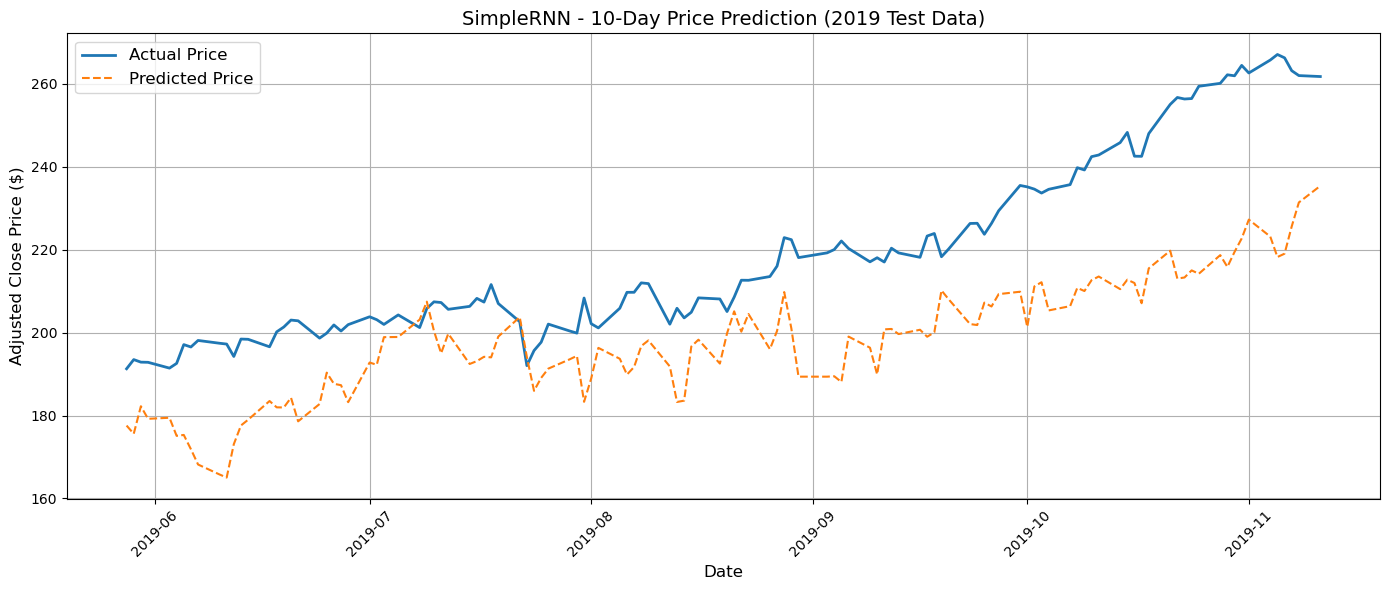


LSTM Evaluation:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step
LSTM - 1-Day MSE: 234.4472


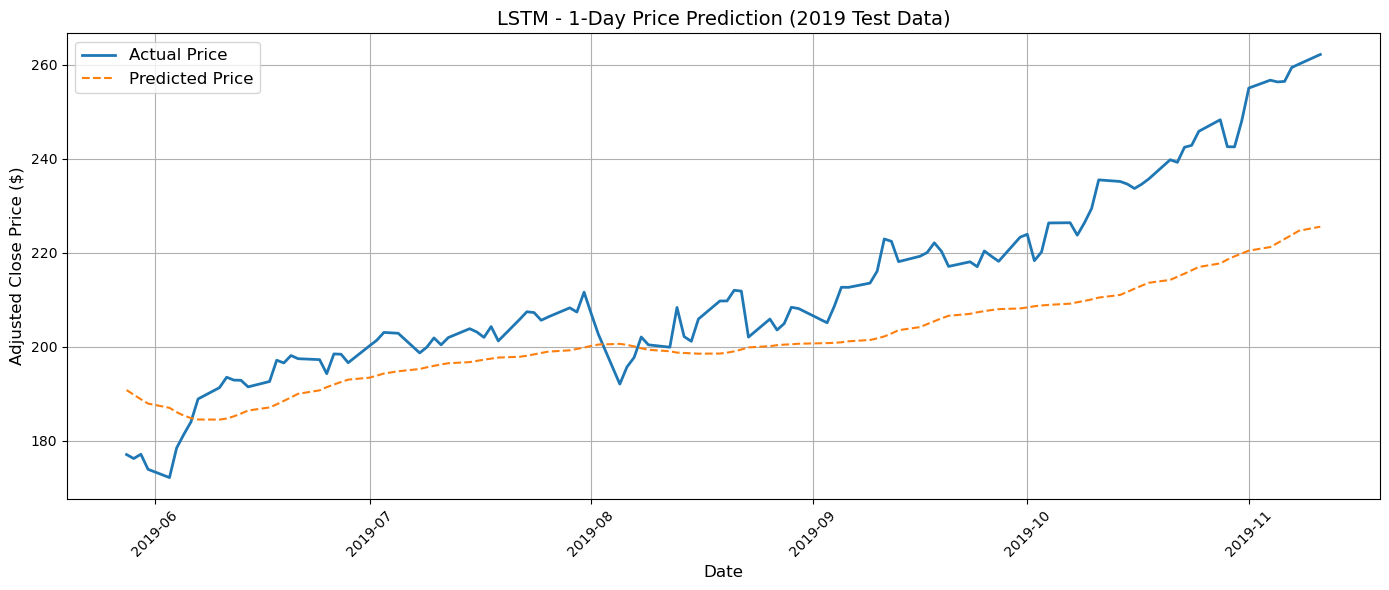

LSTM - 5-Day MSE: 214.8102


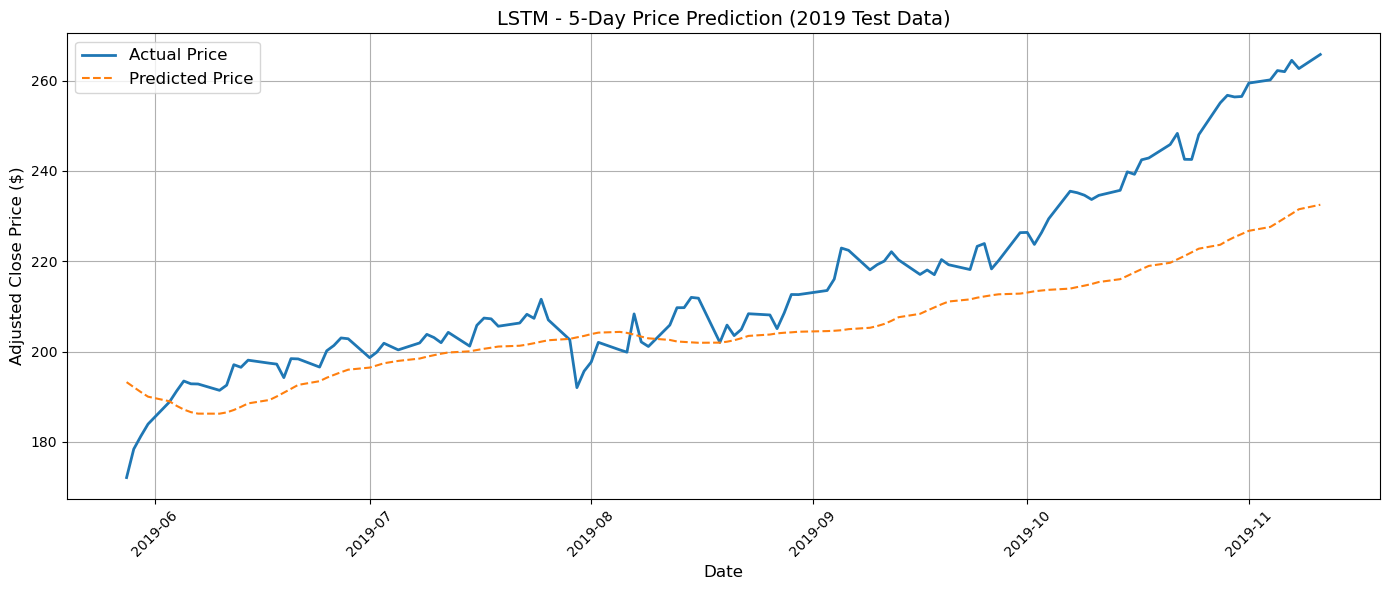

LSTM - 10-Day MSE: 494.9198


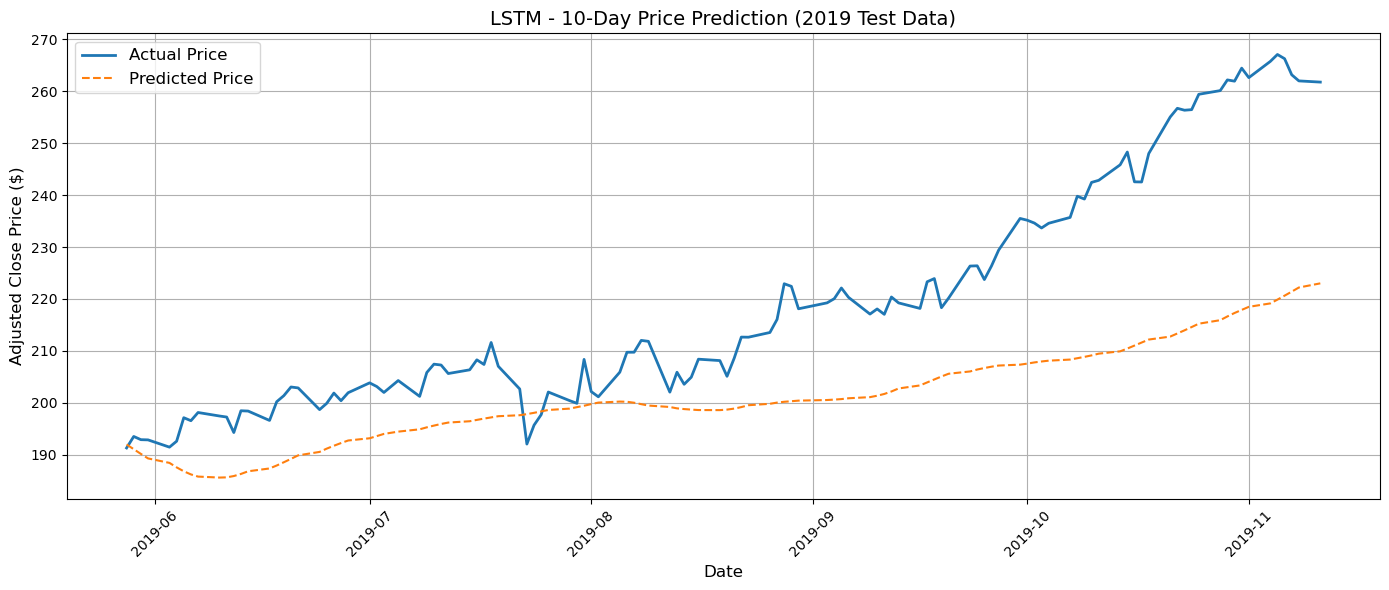


Model Comparison


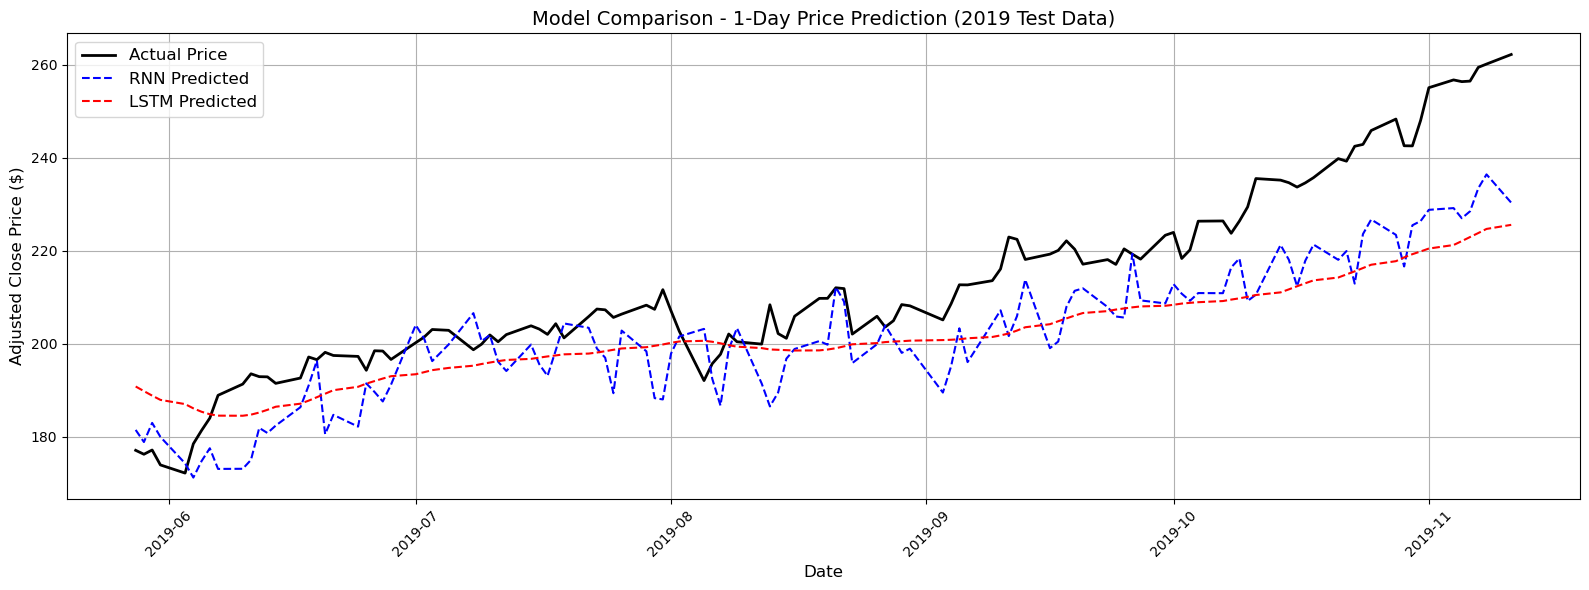

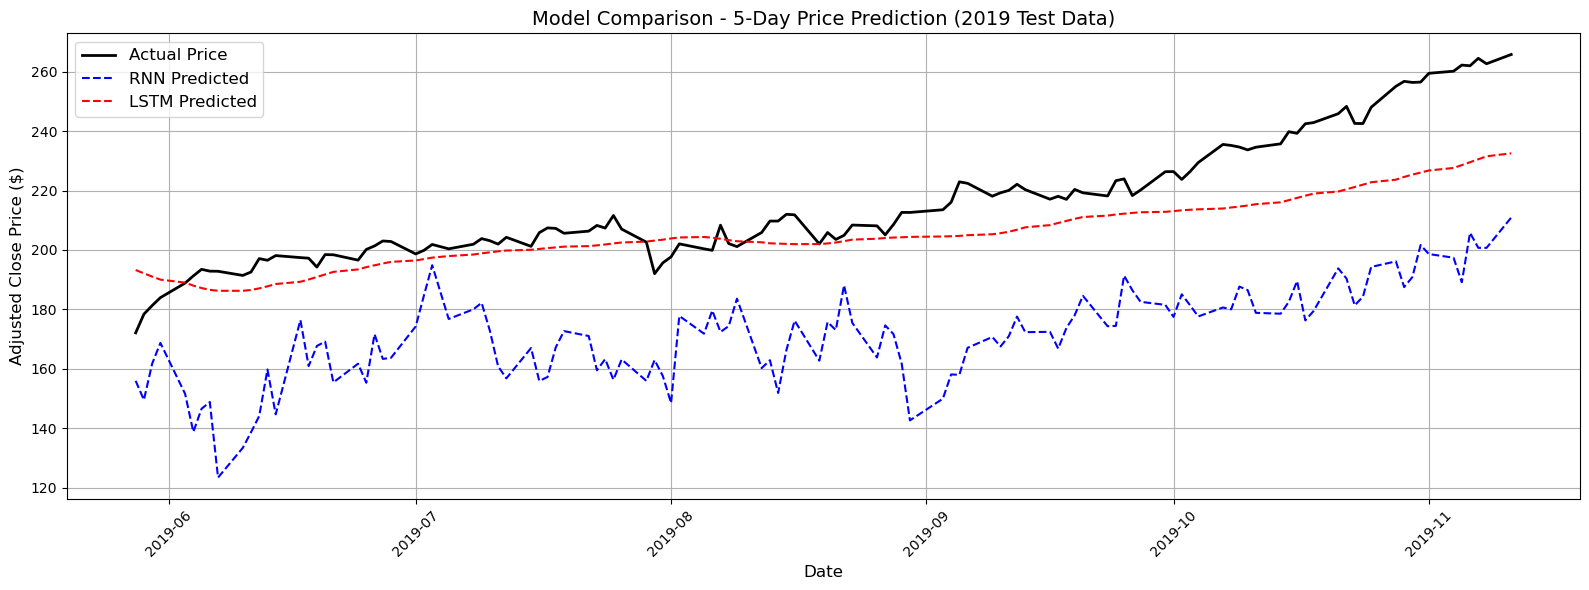

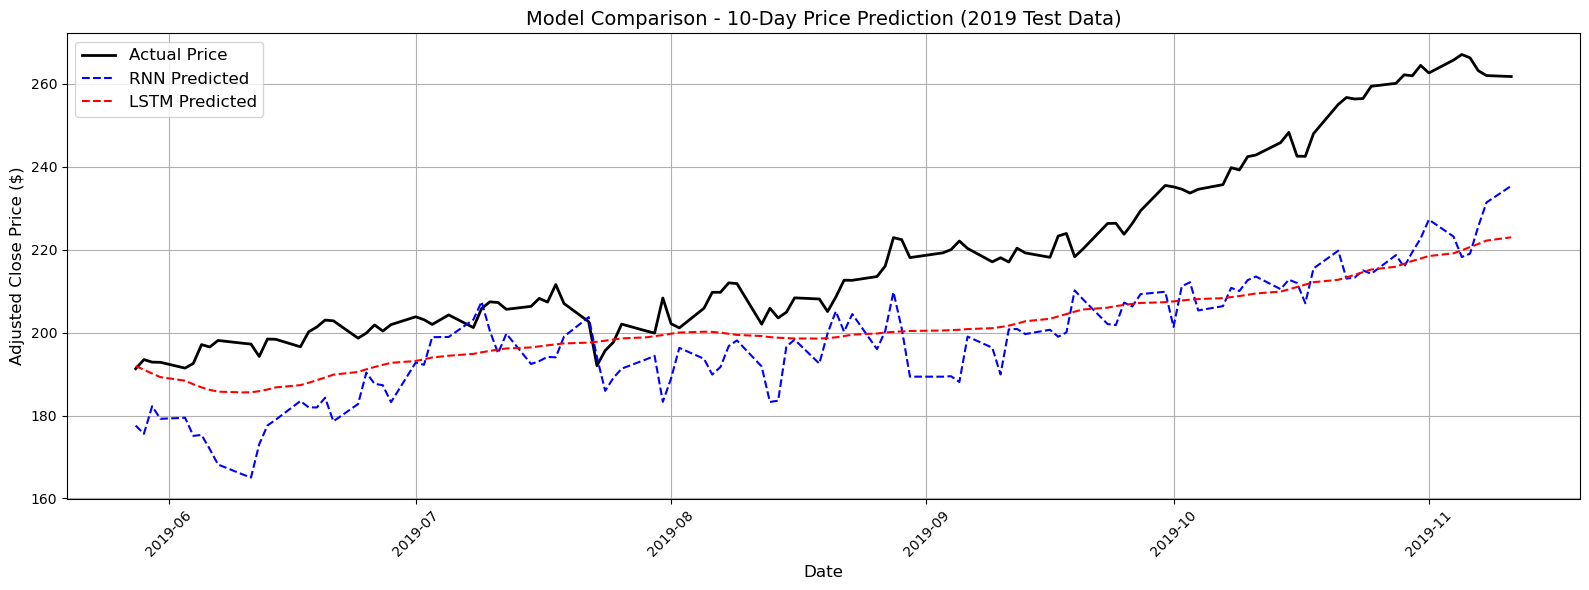

Models saved successfully!


In [196]:
# Model Evaluation
print("\nSimpleRNN Evaluation:")
rnn_results = evaluate_model(rnn_model, X_test, y_test, test_pred_dates, scaler,"SimpleRNN")

print("\nLSTM Evaluation:")
lstm_results = evaluate_model(lstm_model, X_test, y_test, test_pred_dates, scaler,"LSTM")

# Plot comparison
print("\nModel Comparison")
plot_comparison(rnn_results, lstm_results)

# Save models
rnn_model.save('simple_rnn_model_100day.h5')
lstm_model.save('lstm_model_100days.h5')
print("Models saved successfully!")